# DSX Example: Prepare Data for Logistic Regression
### Environment
```
Python 2.7
Spark 2.0
scikit-learn 0.17
```

### History
Notbook moved over from DSX Example 1 project 9 Feb 17

### Citation: UCI ML Repository
Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.  

<p><p>This example uses the Adult dataset taken from the 1994 US Census database.  See: https://archive.ics.uci.edu/ml/datasets/Adult

In [1]:
# Use this magik to get a list of all installed libraries and their versions
!pip list --isolated

Babel (2.1.1)
backports-abc (0.4)
backports.shutil-get-terminal-size (1.0.0)
backports.ssl-match-hostname (3.4.0.2)
basemap (1.0.7)
beautifulsoup4 (4.4.1)
biopython (1.66)
bitarray (0.8.1)
bokeh (0.10.0)
brunel (1.1)
cdsax-jupyter-extensions (0.1)
certifi (2015.11.20.1)
cognitive-assistant (1.0.25)
configparser (3.5.0)
cycler (0.9.0)
Cython (0.23.4)
debtcollector (1.1.0)
decorator (4.0.6)
descartes (1.0.1)
dill (0.2.5)
dlaas-client (1.1.1)
entrypoints (0.2.2)
enum (0.4.6)
extras (0.0.3)
fixtures (2.0.0)
Flask (0.10.1)
funcsigs (0.4)
functools32 (3.2.3.post2)
future (0.15.2)
futures (3.0.5)
geopy (1.11.0)
ibmdbpy (0.1.3.post6)
ip-associations-python-novaclient-ext (0.1)
ipykernel (4.3.1)
ipython (4.2.0)
ipython-genutils (0.1.0)
ipywidgets (5.1.5)
iso8601 (0.1.11)
itsdangerous (0.24)
JayDeBeApi (0.2.0)
Jinja2 (2.8)
JPype1 (0.6.1)
jsonschema (2.5.1)
jupyter-client (4.2.2)
jupyter-console (4.1.1)
jupyter-core (4.1.0)
jupyter-kernel-gateway (1.0.0)
jupyter-pip (0.3)
keyring (5.7)
keystoneau

## STEP 1:  Import Data
We're going to use data from the UC Irvine Machine Learning Repository [ http://archive.ics.uci.edu/ml ].  The data consists of a sample from the 1994 US Census, with the target variable being whether the individual earned more or less than $50,000 per year.  Between the training set and the test set, there are a little over 48,800 cases.  Most of the columns are self explanatory, but three may be unfamiliar:
```
cap_gain : capital gains from personal investments
cap_loss : capital losses from personal investments
fnlwgt   : sampling weight assigned by the US Census
```

In [2]:
import pandas as pd
import numpy as np

In [3]:
new_header = ['age','work_class','fnlwgt','education','education_num',
             'marital_status','occupation','relationship','race','sex',
             'cap_gain','cap_loss','hrs_per_week',
             'native_country','income_class']

In [4]:
dfTrain = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None, names=new_header)
dfTest  = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', header=None, names=new_header)

In [5]:
# The UCIMLR reports 48842 rows in the data set, we have an extra ...
rowsTrain = dfTrain['age'].count()
rowsTest = dfTest['age'].count()
print rowsTrain + rowsTest

48843


In [6]:
# Aha! the first row in the Test set isn't a row.  We need to skip it, or remove it
dfTest[0:5]

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hrs_per_week,native_country,income_class
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
2,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
3,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
4,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.


In [7]:
dfTest = dfTest.drop(dfTest.index[0])
#Re-index from 0!
dfTest = dfTest.reset_index()

In [8]:
# This shows that we now have the number of expected rows, as documented in the UCI repository
dfTest['age'].count() + rowsTrain

48842

## STEP 2:  Explore the data
Let's look at the values in the data set and the distributions of those values.  We'll also look for missing values to get some sense of the data quality

### Look at the distribution of continuous values

In [9]:
dfTrain.describe()

,age,fnlwgt,education_num,cap_gain,cap_loss,hrs_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,189778.366512,10.080679,1077.648844,87.303830,40.437456
std,13.640433,105549.977697,2.572720,7385.292085,402.960219,12.347429
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,117827.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,178356.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,237051.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


### Look at the unique values of the categorical attributes

In [10]:
work_class_vals = dfTrain['work_class'].unique()
education_vals = dfTrain['education'].unique()
marital_status_vals = dfTrain['marital_status'].unique()
occupation_vals = dfTrain['occupation'].unique()
relationship_vals = dfTrain['relationship'].unique()
race_vals = dfTrain['race'].unique()
sex_vals = dfTrain['sex'].unique()
native_country_vals = dfTrain['native_country'].unique()
income_class_vals = dfTrain['income_class'].unique()

In [11]:
print work_class_vals
print education_vals
print marital_status_vals
print occupation_vals
print relationship_vals
print race_vals
print sex_vals
print native_country_vals
print income_class_vals

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
[' Male' ' Female']
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' 

### Check for missing data / nulls

In [12]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
work_class        32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
cap_gain          32561 non-null int64
cap_loss          32561 non-null int64
hrs_per_week      32561 non-null int64
native_country    32561 non-null object
income_class      32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [13]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16281 entries, 0 to 16280
Data columns (total 16 columns):
index             16281 non-null int64
age               16281 non-null object
work_class        16281 non-null object
fnlwgt            16281 non-null float64
education         16281 non-null object
education_num     16281 non-null float64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
cap_gain          16281 non-null float64
cap_loss          16281 non-null float64
hrs_per_week      16281 non-null float64
native_country    16281 non-null object
income_class      16281 non-null object
dtypes: float64(5), int64(1), object(10)
memory usage: 2.1+ MB


###  Analysis of Categorical Values
It's useful to know the various values each categorical attribute takes, and the distribution of each of those values in the column

In [14]:
work_class_counts = dfTrain['work_class'].value_counts()
education_counts = dfTrain['education'].value_counts()
marital_status_counts = dfTrain['marital_status'].value_counts()
occupation_counts = dfTrain['occupation'].value_counts()
relationship_counts = dfTrain['relationship'].value_counts()
race_counts = dfTrain['race'].value_counts()
sex_counts = dfTrain['sex'].value_counts()
native_country_counts = dfTrain['native_country'].value_counts()
income_class_counts = dfTrain['income_class'].value_counts()

In [15]:
print work_class_counts
print ''
print education_counts
print ''
print marital_status_counts
print ''
print occupation_counts
print ''
print relationship_counts
print ''
print race_counts
print ''
print sex_counts
print ''
print native_country_counts
print ''
print income_class_counts

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: work_class, dtype: int64

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64

 Prof-specialty       4140
 Craft-repair         4099
 Exec-manage

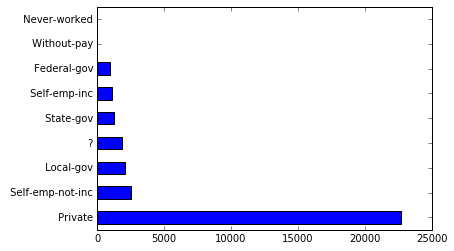

In [16]:
%matplotlib inline
work_class_counts.plot('barh')

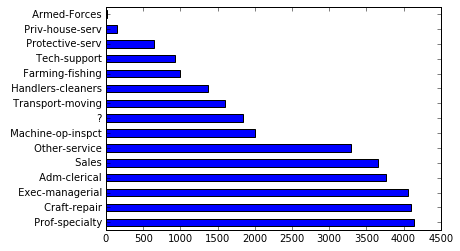

In [17]:
occupation_counts.plot('barh')
#relationship_counts.plot('kde')

## STEP 3: Prepare data sets for Logistic Regression
There're a couple of characteristics of logistic regression that we need to consider when preparing data.
<p>(1) Are we predicting a binary class, or are we predicting one of multiple classes?
<p>(2) What types of input are we using (categorical, ordinal, numeric).  
<p>(3) Do we need to deal with missing data?



In [18]:
dfTrain[0:2]

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hrs_per_week,native_country,income_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


### Standardize the continuous variables and convert categoricals to one-hot encoding

In [19]:
# Standardization
dfTrainContinuous = pd.DataFrame({'age'    : np.float64(dfTrain.age), 
                                  'cap_loss' : np.float64(dfTrain.cap_loss), 
                                  'cap_gain' : np.float64(dfTrain.cap_gain), 
                                  'education_num' : np.float64(dfTrain.education_num), 
                                  'hrs_per_week'  : np.float64(dfTrain.hrs_per_week),
                                  'sample_weight' : np.float64(dfTrain.fnlwgt)})

dfTrainContinuousStd = dfTrainContinuous.apply(lambda x: (x - np.mean(x)) / ((np.max(x) - np.min(x))))

In [20]:
# One-hot encoding
dfTrainCategoricalStd = pd.get_dummies(pd.concat([dfTrain.work_class, dfTrain.education, 
                                                  dfTrain.marital_status, dfTrain.occupation, 
                                                  dfTrain.relationship, dfTrain.race, dfTrain.sex,
                                                  dfTrain.native_country], axis=1))



In [21]:
#Clean up column names
def clean_col_names( list_of_names ):
    new_list = []
    for name in list_of_names:
        res = name.replace(" ","")
        res = res.replace("-", "_")
        res = res.replace("(", "_")
        res = res.replace(")","_")
        res = res.replace("?", "unknown")
        new_list.append(res)
    return new_list
                          

dfTrainCategoricalStd.columns = clean_col_names(list(dfTrainCategoricalStd))

### Construct the Training Data Dataframe

In [22]:
dfTrainStd = pd.concat([dfTrainContinuousStd, dfTrainCategoricalStd], axis=1)
dfTrainStd[0:10]

,age,cap_gain,cap_loss,education_num,hrs_per_week,sample_weight,work_class_unknown,work_class_Federal_gov,work_class_Local_gov,work_class_Never_worked,...,native_country_Portugal,native_country_Puerto_Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United_States,native_country_Vietnam,native_country_Yugoslavia
0,0.005731,0.010964,-0.020042,0.194621,-0.004464,-0.076243,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.156416,-0.010777,-0.020042,0.194621,-0.279974,-0.072308,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.007968,-0.010777,-0.020042,-0.072045,-0.004464,0.017568,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.197512,-0.010777,-0.020042,-0.205379,-0.004464,0.030523,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.144954,-0.010777,-0.020042,0.194621,-0.004464,0.100943,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.021666,-0.010777,-0.020042,0.261288,-0.004464,0.064386,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0.142717,-0.010777,-0.020042,-0.338712,-0.249362,-0.020097,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.183813,-0.010777,-0.020042,-0.072045,0.046557,0.013490,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,-0.103858,0.130065,-0.020042,0.261288,0.097577,-0.097796,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0.046827,0.041004,-0.020042,0.194621,-0.004464,-0.020598,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Create the array of labels

In [23]:
df_TrainIncomeClass = pd.DataFrame(np.where(dfTrain.income_class == ' >50K', 1, 0))

In [24]:
df_TrainIncomeClass[0:10]

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,1
8,1
9,1


## Standardize values in Test Set

In [25]:
dfTestContinuous = pd.DataFrame({'age'    : np.float64(dfTest.age), 
                               'cap_loss' : np.float64(dfTest.cap_loss), 
                               'cap_gain' : np.float64(dfTest.cap_gain), 
                               'education_num' : np.float64(dfTest.education_num), 
                               'hrs_per_week'  : np.float64(dfTest.hrs_per_week),
                               'sample_weight' : np.float64(dfTest.fnlwgt)})
dfTestContinuousStd = dfTestContinuous.apply(lambda x: (x - np.mean(x)) / ((np.max(x) - np.min(x))))

In [26]:
dfTestContinuousStd[0:5]

,age,cap_gain,cap_loss,education_num,hrs_per_week,sample_weight
0,-0.188595,-0.010819,-0.023315,-0.204860,-0.004002,0.025300
1,-0.010513,-0.010819,-0.023315,-0.071527,0.098038,-0.067453
2,-0.147499,-0.010819,-0.023315,0.128473,-0.004002,0.099881
3,0.071679,0.066062,-0.023315,-0.004860,-0.004002,-0.019712
4,-0.284486,-0.010819,-0.023315,-0.004860,-0.106043,-0.058188


In [27]:
dfTestCategoricalStd = pd.get_dummies(pd.concat([dfTest.work_class, dfTest.education, dfTest.marital_status, dfTest.occupation, dfTest.relationship, dfTest.race, dfTest.sex,
                          dfTest.native_country], axis=1))
dfTestCategoricalStd[0:5]

,work_class_ ?,work_class_ Federal-gov,work_class_ Local-gov,work_class_ Never-worked,work_class_ Private,work_class_ Self-emp-inc,work_class_ Self-emp-not-inc,work_class_ State-gov,work_class_ Without-pay,education_ 10th,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Clean up the column names

In [28]:
dfTestCategoricalStd.columns = clean_col_names(list(dfTestCategoricalStd))

### Construct the Test set data frame

In [29]:
dfTestStd = pd.concat([dfTestContinuousStd, dfTestCategoricalStd], axis=1)
dfTestStd[0:5]

,age,cap_gain,cap_loss,education_num,hrs_per_week,sample_weight,work_class_unknown,work_class_Federal_gov,work_class_Local_gov,work_class_Never_worked,...,native_country_Portugal,native_country_Puerto_Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United_States,native_country_Vietnam,native_country_Yugoslavia
0,-0.188595,-0.010819,-0.023315,-0.204860,-0.004002,0.025300,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-0.010513,-0.010819,-0.023315,-0.071527,0.098038,-0.067453,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.147499,-0.010819,-0.023315,0.128473,-0.004002,0.099881,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.071679,0.066062,-0.023315,-0.004860,-0.004002,-0.019712,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.284486,-0.010819,-0.023315,-0.004860,-0.106043,-0.058188,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Ensure that both datasets have the same set of one-hot columns
Note that the TrainingStd dataset has 108 columns, while TestStd has only 107.  This is because the Training set has one country value not present in the Test set:  'Holand-Netherlands' (sic).  For completeness, we add a dummy column to Test...

In [30]:
dfTestStd['native_country_Holand_Netherlands'] = 0

### Create the array of Test Labels

In [31]:
df_TestIncomeClass = pd.DataFrame(np.where(dfTest.income_class == ' >50K', 1, 0))

## Write prepared Training and Test sets to Bluemix Object Storage

In [32]:
# The code was removed by DSX for sharing.

In [33]:
import requests  
import json

def put_file(credentials, local_file_name):  
    """This function writes file content to Object Storage V3 """
    f = open(local_file_name,'r')
    my_data = f.read()
    
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', local_file_name])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'text/csv'}
    resp2 = requests.put(url=url2, headers=headers2, data = my_data )
    return resp2

### Save data to local storage

In [34]:
# index=False tells the writer to ignore the dataframe index column when writing out the data
dfTrainStd.to_csv('TrainStd.csv', index=False)
dfTestStd.to_csv('TestStd.csv', index=False)

# save the labels, too
df_TrainIncomeClass.to_csv( 'TrainIncomeClassLabels.csv', index=False)
df_TestIncomeClass.to_csv('TestIncomeClassLabels.csv', index=False)

### Write the data to Bluemix Object Store
Note HTTP response code 201 means the operation completed successfully and a new resource was created on the server.

In [35]:
resp = put_file( credentials, 'TrainStd.csv')
print resp

<Response [201]>


In [36]:
resp = put_file( credentials, 'TestStd.csv')
print resp

<Response [201]>


In [37]:
resp = put_file( credentials, 'TestIncomeClassLabels.csv')
print resp

<Response [201]>


In [38]:
resp = put_file( credentials, 'TrainIncomeClassLabels.csv')
print resp


<Response [201]>


#### The following cell is for debugging ...

In [39]:
with open('TestStd.csv', 'rb') as f:
    x = f.readline()
    print x
    x = f.readline()
    print '---'
    print x

age,cap_gain,cap_loss,education_num,hrs_per_week,sample_weight,work_class_unknown,work_class_Federal_gov,work_class_Local_gov,work_class_Never_worked,work_class_Private,work_class_Self_emp_inc,work_class_Self_emp_not_inc,work_class_State_gov,work_class_Without_pay,education_10th,education_11th,education_12th,education_1st_4th,education_5th_6th,education_7th_8th,education_9th,education_Assoc_acdm,education_Assoc_voc,education_Bachelors,education_Doctorate,education_HS_grad,education_Masters,education_Preschool,education_Prof_school,education_Some_college,marital_status_Divorced,marital_status_Married_AF_spouse,marital_status_Married_civ_spouse,marital_status_Married_spouse_absent,marital_status_Never_married,marital_status_Separated,marital_status_Widowed,occupation_unknown,occupation_Adm_clerical,occupation_Armed_Forces,occupation_Craft_repair,occupation_Exec_managerial,occupation_Farming_fishing,occupation_Handlers_cleaners,occupation_Machine_op_inspct,occupation_Other_service,occupat